In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import sys
import os
import math
import pathlib
import re
import gc

from typing import List, Dict, Tuple, Iterator, Iterable, Optional, Callable

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

pd.set_option("display.max_columns", None)


In [2]:
dataset_path = pathlib.Path(
    "/home/daifukusan/Storage/datasets/tabular-playground-series-dec-2021"
)


In [74]:
dtype = {"Cover_Type": pd.CategoricalDtype()}

df_train = pd.read_csv(dataset_path.joinpath("train.csv"), dtype=dtype)
df_test = pd.read_csv(dataset_path.joinpath("test.csv"), dtype=dtype)


# df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, stratify=df[['Cover_Type']])


In [75]:
def reduce_mem_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024 ** 2

    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )

    return df


In [76]:
cover_labels = [
    "Spruce/Fir",
    "Lodgepole Pine",
    "Ponderosa Pine",
    "Cottonwood/Willow",
    "Aspen",
    "Douglas-fir",
    "Krummholz",
]

wilderness_labels = [
    "Rawah Wilderness Area",
    "Neota Wilderness Area",
    "Comanche Peak Wilderness Area",
    "Cache la Poudre Wilderness Area",
]

soil_labels = [
    "Cathedral family - Rock outcrop complex, extremely stony.",
    "Vanet - Ratake families complex, very stony.",
    "Haploborolis - Rock outcrop complex, rubbly.",
    "Ratake family - Rock outcrop complex, rubbly.",
    "Vanet family - Rock outcrop complex complex, rubbly.",
    "Vanet - Wetmore families - Rock outcrop complex, stony.",
    "Gothic family.",
    "Supervisor - Limber families complex.",
    "Troutville family, very stony.",
    "Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    "Bullwark - Catamount families - Rock land complex, rubbly.",
    "Legault family - Rock land complex, stony.",
    "Catamount family - Rock land - Bullwark family complex, rubbly.",
    "Pachic Argiborolis - Aquolis complex.",
    "unspecified in the USFS Soil and ELU Survey.",
    "Cryaquolis - Cryoborolis complex.",
    "Gateview family - Cryaquolis complex.",
    "Rogert family, very stony.",
    "Typic Cryaquolis - Borohemists complex.",
    "Typic Cryaquepts - Typic Cryaquolls complex.",
    "Typic Cryaquolls - Leighcan family, till substratum complex.",
    "Leighcan family, till substratum, extremely bouldery.",
    "Leighcan family, till substratum - Typic Cryaquolls complex.",
    "Leighcan family, extremely stony.",
    "Leighcan family, warm, extremely stony.",
    "Granile - Catamount families complex, very stony.",
    "Leighcan family, warm - Rock outcrop complex, extremely stony.",
    "Leighcan family - Rock outcrop complex, extremely stony.",
    "Como - Legault families complex, extremely stony.",
    "Como family - Rock land - Legault family complex, extremely stony.",
    "Leighcan - Catamount families complex, extremely stony.",
    "Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    "Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    "Cryorthents - Rock land complex, extremely stony.",
    "Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    "Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    "Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    "Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    "Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    "Moran family - Cryorthents - Rock land complex, extremely stony.",
]

field_labels = {
    "Elevation": ("numerical", None, "Elevation in meters"),
    "Aspect": ("numerical", None, "Aspect in degrees azimuth"),
    "Slope": ("numerical", None, "Slope in degrees"),
    "Horizontal_Distance_To_Hydrology": (
        "numerical",
        None,
        "Horz Dist to nearest surface water features",
    ),
    "Vertical_Distance_To_Hydrology": (
        "numerical",
        None,
        "Vert Dist to nearest surface water features",
    ),
    "Horizontal_Distance_To_Roadways": (
        "numerical",
        None,
        "Horz Dist to nearest roadway",
    ),
    "Hillshade_9am": ("numerical", None, "Hillshade index at 9am, summer solstice"),
    "Hillshade_Noon": ("numerical", None, "Hillshade index at noon, summer solstice"),
    "Hillshade_3pm": ("numerical", None, "Hillshade index at 3pm, summer solstice"),
    "Horizontal_Distance_To_Fire_Points": (
        "numerical",
        None,
        "Horz Dist to nearest wildfire ignition points",
    ),
    "Wilderness_Area": ("one_hot", wilderness_labels, "Wilderness area designation"),
    "Soil_Type": ("one_hot", soil_labels, "Soil Type designation"),
    "Cover_Type": ("categorical", cover_labels, "Forest Cover Type designation"),
}

one_hot_pattern = re.compile("^([\w_]+)(\d+)$")


def extract_name_number(x: str):
    name, number = one_hot_pattern.match(x).groups()[0:2]
    return name, int(number)


def search_label(x: str, labels: Iterable[str]):
    for label in labels:
        if x.startswith(label):
            return label

    raise ValueError()


def print_labels(
    columns: Iterable[str], labels: Dict[str, Tuple[str, Optional[List[str]], str]]
):
    for column in columns:
        key = None

        if column in field_labels:
            key = column
        else:
            key = search_label(column, labels)

        dtype, sublabels, label = field_labels[key]

        out = [column, label]

        if sublabels:
            if dtype == "categorical":
                out.append(sublabels[int(dtype)])
            elif dtype == "one_hot":
                out.append(sublabels[extract_name_number(column)[1]])

        print(" :: ".join(out))


pipeline: List[Callable[[pd.DataFrame], pd.DataFrame]] = []


In [77]:
"Soil_Type15".startswith("Soil_Type")


True

## Cleanup

First, we will remove columns that give us no information whatsoever, i.e. columns of variance equal to zero.


In [78]:
columns_before = df_train.columns

df_train = df_train.loc[:, df_train.nunique() > 1]
df_train = df_train.drop(df_train[df_train["Cover_Type"] == "5"].index, axis=0)


These columns are the following:


In [79]:
removed_columns = set(columns_before).difference(df_train.columns)

df_test = df_test.drop(columns=list(removed_columns))

print_labels(removed_columns, field_labels)

pipeline.append(lambda x: x.drop(columns=list(removed_columns)))


Soil_Type15 :: Soil Type designation :: Vanet - Wetmore families - Rock outcrop complex, stony.
Soil_Type7 :: Soil Type designation :: Supervisor - Limber families complex.


Now let's see if there are any discrepencies in our data:


In [80]:
df_train.describe()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06
mean,1.999999e+06,2.980192e+03,1.515857e+02,1.509753e+01,2.713155e+02,5.166261e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,1.581405e+03,2.611931e-01,4.166101e-02,6.535732e-01,2.181901e-02,1.684150e-02,3.089601e-02,4.275501e-03,3.791251e-02,1.571525e-02,7.972752e-03,2.899751e-03,1.089300e-02,5.454076e-02,2.798526e-02,1.829000e-02,3.129526e-02,1.497650e-02,1.588850e-02,2.067176e-02,1.343625e-02,1.381125e-02,1.736800e-02,1.153900e-02,3.134601e-02,4.917076e-02,2.502176e-02,3.258251e-03,1.352700e-02,1.176575e-02,1.070775e-02,2.227351e-02,2.886701e-02,2.749326e-02,3.746201e-02,3.782076e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075151e-02,3.923926e-02,3.161851e-02
std,1.154701e+06,2.890482e+02,1.099611e+02,8.546724e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,1.127612e+03,4.392850e-01,1.998134e-01,4.758312e-01,1.460922e-01,1.286774e-01,1.730360e-01,6.524739e-02,1.909847e-01,1.243716e-01,8.893362e-02,5.377121e-02,1.037996e-01,2.270817e-01,1.649306e-01,1.339981e-01,1.741145e-01,1.214587e-01,1.250442e-01,1.422830e-01,1.151335e-01,1.167069e-01,1.306383e-01,1.067982e-01,1.742511e-01,2.162244e-01,1.561911e-01,5.698803e-02,1.155163e-01,1.078301e-01,1.029228e-01,1.475717e-01,1.674327e-01,1.635157e-01,1.898911e-01,1.907626e-01,1.088629e-01,1.256813e-01,1.029466e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01
min,0.000000e+00,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,-2.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.999995e+05,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,7.810000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

We can see a few of them:

- Hillshade should be a value going from 0 to 255
- Slope and Aspect should be a value going from 0 do 360
- Distance should be a positive value


## Feature Engineering

Let's try find new features.

We have a horizontal and vertical distance, we could calculate the Euclidian and Manhattan distance. We also could count


In [81]:
wilderness_pattern = re.compile("^Wilderness_Area\d+$")
soil_pattern = re.compile("^Soil_Type\d+$")

wilderness_cols = lambda df: sorted(
    [x for x in df.columns if wilderness_pattern.match(x)], key=extract_name_number
)
soil_cols = lambda df: sorted(
    [x for x in df.columns if soil_pattern.match(x)], key=extract_name_number
)
one_hot_cols = lambda df: wilderness_cols(df) + soil_cols(df)
numeric_cols = lambda df: sorted(
    list(set(df.columns) - (set(one_hot_cols(df)) | {"Id", "Cover_Type"}))
)


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:

    for column in ["Aspect", "Slope"]:
        df.loc[df[column] < 0, column] += 360
        df.loc[df[column] > 359, column] -= 360
        df[f"{column}180"] = (
            df[column].copy().apply(lambda x: x + 180 if x + 180 < 360 else x - 180)
        )

    for column in ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]:
        df[column].clip(0, 255)

    df["Euclidian_Distance_To_Hydrology"] = np.square(
        df["Horizontal_Distance_To_Hydrology"].astype(np.float64)
    ) + np.square(df["Vertical_Distance_To_Hydrology"].astype(np.float64))
    df["Manhattan_Distance_to_Hydrolody"] = abs(
        df["Horizontal_Distance_To_Hydrology"]
    ) + abs(df["Vertical_Distance_To_Hydrology"])

    df["Soil_Type_Count"] = df[soil_cols(df)].sum(axis=1)
    df["Wilderness_Area_Count"] = df[wilderness_cols(df)].sum(axis=1)

    return df


In [82]:
df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)


Mem. usage decreased to 331.88 Mb (81.9% reduction)
Mem. usage decreased to 74.39 Mb (83.5% reduction)


In [83]:
df_train.describe()


,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Aspect180,Slope180,Euclidian_Distance_To_Hydrology,Manhattan_Distance_to_Hydrolody,Soil_Type_Count,Wilderness_Area_Count
count,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06,3.999999e+06
mean,1.999999e+06,2.980192e+03,1.488886e+02,1.580151e+01,2.713155e+02,5.166261e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,1.581405e+03,2.611931e-01,4.166101e-02,6.535732e-01,2.181901e-02,1.684150e-02,3.089601e-02,4.275501e-03,3.791251e-02,1.571525e-02,7.972752e-03,2.899751e-03,1.089300e-02,5.454076e-02,2.798526e-02,1.829000e-02,3.129526e-02,1.497650e-02,1.588850e-02,2.067176e-02,1.343625e-02,1.381125e-02,1.736800e-02,1.153900e-02,3.134601e-02,4.917076e-02,2.502176e-02,3.258251e-03,1.352700e-02,1.176575e-02,1.070775e-02,2.227351e-02,2.886701e-02,2.749326e-02,3.746201e-02,3.782076e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075151e-02,3.923926e-02,3.161851e-02,2.072311e+02,1.950975e+02,1.322593e+05,3.269484e+02,8.285007e-01,9.782462e-01
std,1.154701e+06,2.890482e+02,1.083610e+02,1.740949e+01,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,1.127612e+03,4.392850e-01,1.998134e-01,4.758312e-01,1.460922e-01,1.286774e-01,1.730360e-01,6.524739e-02,1.909847e-01,1.243716e-01,8.893362e-02,5.377121e-02,1.037996e-01,2.270817e-01,1.649306e-01,1.339981e-01,1.741145e-01,1.214587e-01,1.250442e-01,1.422830e-01,1.151335e-01,1.167069e-01,1.306383e-01,1.067982e-01,1.742511e-01,2.162244e-01,1.561911e-01,5.698803e-02,1.155163e-01,1.078301e-01,1.029228e-01,1.475717e-01,1.674327e-01,1.635157e-01,1.898911e-01,1.907626e-01,1.088629e-01,1.256813e-01,1.029466e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,8.973458e+01,8.546724e+00,2.305223e+05,2.366878e+02,8.571704e-01,3.183765e-01
min,0.000000e+00,1.773000e+03,0.000000e+00,0.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,-2.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.770000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.999995e+05,2.760000e+03,5.900000e+01,9.000000e+00,1.100000e+02,

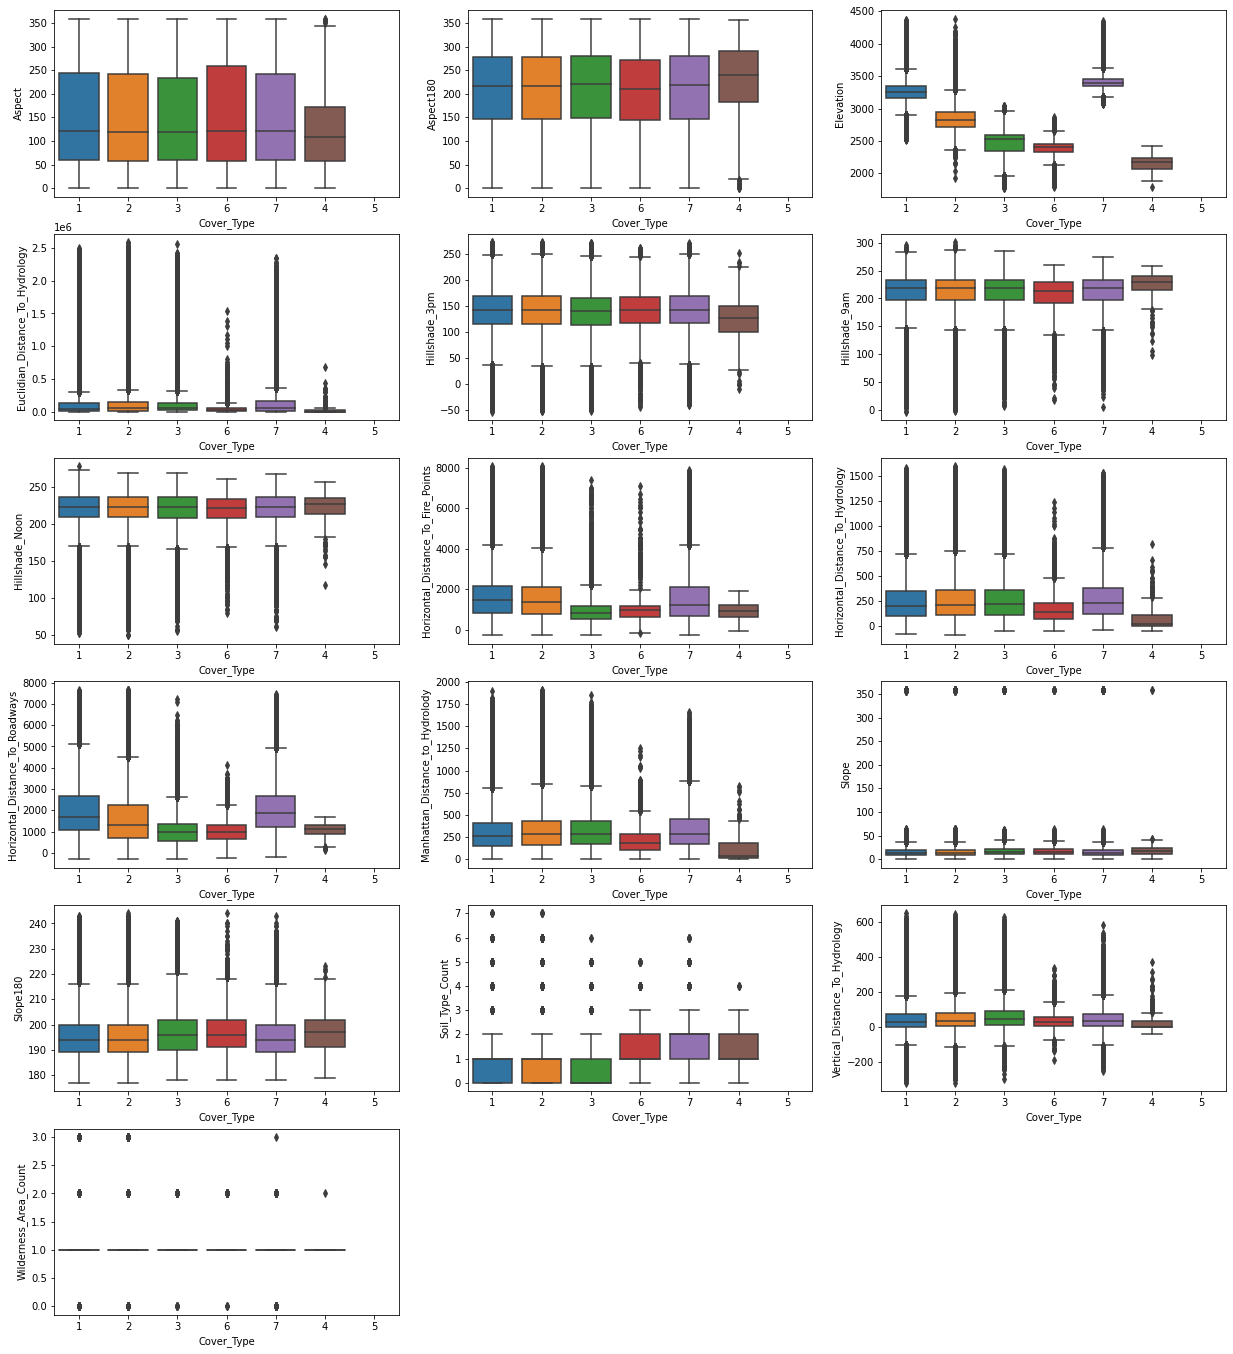

In [84]:
nrows = math.ceil(len(numeric_cols(df_train)) / 3)
ncols = 3

fig = plt.figure()
fig.set_figheight(nrows * 4)
fig.set_figwidth(ncols * 7)

for i, column in enumerate(numeric_cols(df_train)):
    ax = plt.subplot(nrows, ncols, i + 1)
    sns.boxplot(x="Cover_Type", y=column, data=df_train, ax=ax)


In [85]:
# fig = plt.figure()
# fig.set_figheight(nrows * 4)
# fig.set_figwidth(ncols * 7)

# for i, column in enumerate(numeric_cols(df_train)):
#     ax = plt.subplot(nrows, ncols, i + 1)
#     sns.violinplot(x="Cover_Type", y=column, data=df_train, ax=ax)


In [86]:
# df_one_hot_count = df_train[['Cover_Type', 'Id'] + one_hot_cols(df_train)].groupby("Cover_Type").sum()
# df_one_hot_count = df_one_hot_count.drop(axis=0, index="5")
# df_one_hot_count


In [87]:
# def normalize(column):
#     return column / column.sum()

# df_one_hot_count_normalized = df_one_hot_count

# for column in one_hot_cols(df_one_hot_count):
#     df_one_hot_count_normalized[column] = normalize(df_one_hot_count[column] / df_one_hot_count['Id'])

# df_one_hot_count_normalized = df_one_hot_count_normalized.drop(columns=['Id'])


In [88]:
# df_one_hot_count_normalized_tr = df_one_hot_count_normalized.transpose()
# df_one_hot_count_normalized_tr["name"], df_one_hot_count_normalized_tr["number"] = zip(
#     *df_one_hot_count_normalized_tr.reset_index()["index"].map(extract_name_number)
# )
# df_one_hot_count_normalized_tr = df_one_hot_count_normalized_tr.sort_values(
#     by=["name", "number"]
# ).drop(columns=["name", "number"])


In [89]:
# fig, ax = plt.subplots(figsize=(7 * 2, 6 * 2))
# sns.heatmap(
#     df_one_hot_count_normalized_tr,
#     annot=True,
#     ax=ax,
# )


In [90]:
# rows = []

# for i, column in enumerate(numeric_cols(df_train) + one_hot_cols(df_train)):
#     F, p = stats.f_oneway(*[df_train[df_train['Cover_Type'] == f"{j}"][column] for j in range(1, 8)])
#     rows.append({
#         "column": column,
#         "F": F,
#         "p": p,
#     })

# df_anova = pd.DataFrame.from_records(rows)
# df_anova.sort_values('F', ascending=False)


In [91]:
# to_dataset = lambda df: (df[numeric_cols(df) + one_hot_cols(df)], df['Id'])

# X, train_id = to_dataset(df_train)
# X_test, test_id = to_dataset(df_test)

# y = df_train['Cover_Type'].astype('int').values - 1
from sklearn.model_selection import train_test_split


In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[numeric_cols(df_train) + one_hot_cols(df_train)],
    df_train["Cover_Type"],
    test_size=0.10,
    random_state=42
    # stratify=df_train['Cover_Type'].astype('int'),
)


In [93]:
import sklearn


In [134]:
column_names = numeric_cols(df_train) + one_hot_cols(df_train)
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    df_train[column_names],
    df_train["Cover_Type"],
    test_size=0.15,
    random_state=random_state
    # stratify=df_train['Cover_Type'].astype('int'),
)

# X_test, X_val, y_test, y_val = train_test_split(
#     X_test,
#     y_test,
#     test_size=0.33,
#     random_state=random_state
#     # stratify=df_train['Cover_Type'].astype('int'),
# )


In [136]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.RobustScaler(),
    sklearn.preprocessing.MinMaxScaler((-1, 1)),
)

le = sklearn.preprocessing.LabelEncoder()
lb = sklearn.preprocessing.LabelBinarizer()

encoder = sklearn.pipeline.make_pipeline(
    le,
    lb,
)

# le.fit([f"{i+1}" for i in range(7)])
le.fit(y_train)

y_train = pd.Series(le.transform(y_train), name=y_train.name)
y_test = pd.Series(le.transform(y_test), name=y_test.name)
# y_val = pd.Series(le.transform(y_val), name=y_val.name)

X_train = pd.DataFrame(pipeline.fit_transform(X_train), columns=column_names)
X_test = pd.DataFrame(pipeline.transform(X_test), columns=column_names)
# X_val = pd.DataFrame(pipeline.fit_transform(X_val), columns=X_val.columns)

X_out = pd.DataFrame(pipeline.transform(df_test[column_names]), columns=column_names)

# dump_path = dataset_path.joinpath("save")
# dump_path.mkdir(parents=True, exist_ok=True)

# var_list = [
#     X_train,
#     X_test,
#     X_val,
#     y_train,
#     y_test,
#     y_val,
#     le,
#     pipeline,
# ]

# name_list = [
#     'X_train',
#     'X_test',
#     'X_val',
#     'y_train',
#     'y_test',
#     'y_val',
#     'le',
#     'pipeline',
# ]

# for var, name in zip(var_list, name_list):
#     joblib.dump(
#         value=var,
#         filename=dump_path.joinpath(name),
#         compress=3,
#     )

# for var, name in zip(var_list[:-2], name_list[:-2]):
#     var.to_csv(dump_path.joinpath(f"{name}.csv"), index=False)


In [105]:
# import joblib

# X_train = joblib.load(dump_path.joinpath('X_train'))
# X_test = joblib.load(dump_path.joinpath('X_test'))
# X_val = joblib.load(dump_path.joinpath('X_val'))
# y_train = joblib.load(dump_path.joinpath('y_train'))
# y_test = joblib.load(dump_path.joinpath('y_test'))
# y_val = joblib.load(dump_path.joinpath('y_val'))
# le = joblib.load(dump_path.joinpath('le'))
# pipeline = joblib.load(dump_path.joinpath('pipeline'))


In [106]:
import xgboost as xgb

import tensorflow as tf

tf.test.is_built_with_cuda()
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [138]:
import aim
import aim.xgboost

path_aim = dataset_path.joinpath("aim")
path_csv = dataset_path.joinpath("csv")

experiment = 'tabular_playground'
model_name = f'{experiment}_0005'
experiment = model_name



In [139]:
xgb_classifier = xgb.sklearn.XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    tree_method="gpu_hist",
    gpu_id=0,
    random_state=42,
    use_label_encoder=False,
    num_class=6,
    max_depth=8,
)


In [140]:
aim_callback = aim.xgboost.AimCallback(repo=str(path_aim.absolute()), experiment=experiment)

xgb_classifier.fit(
    X_train.astype("float32"),
    np.vstack(y_train),
    early_stopping_rounds=3,
    eval_set=[(X_test.astype("float32"), np.vstack(y_test))],
    callbacks=[
        aim_callback
    ],
)

# run["hparams"] = dict(
#     (a, b)
#     for a, b in xgb_classifier.get_params().items()
#     if b and (type(b) != float or not np.isnan(b))
# )

# run.finalize()

xgb_classifier.save_model(dataset_path.joinpath("save", f"{model_name}.model"))

[03:32:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.29430
[1]	validation_0-mlogloss:1.01494
[2]	validation_0-mlogloss:0.82214
[3]	validation_0-mlogloss:0.67957
[4]	validation_0-mlogloss:0.57012
[5]	validation_0-mlogloss:0.48436
[6]	validation_0-mlogloss:0.41616
[7]	validation_0-mlogloss:0.36145
[8]	validation_0-mlogloss:0.31703
[9]	validation_0-mlogloss:0.28074
[10]	validation_0-mlogloss:0.25103
[11]	validation_0-mlogloss:0.22644
[12]	validation_0-mlogloss:0.20591
[13]	validation_0-mlogloss:0.18904
[14]	validation_0-mlogloss:0.17511
[15]	validation_0-mlogloss:0.16330
[16]	validation_0-mlogloss:0.15340
[17]	validation_0-mlogloss:0.14510
[18]	validation_0-mlogloss:0.13803
[19]	validation_0-mlogloss:0.13187
[20]	validation_0-mlogloss:0.12677
[21]	validation_0-mlog

In [88]:
# df_importance = pd.concat(
#     [
#         pd.DataFrame(column_names, columns=["feature_name"]),
#         pd.DataFrame(
#             xgb_classifier.feature_importances_, columns=["feature_importance"]
#         ),
#     ],
#     axis=1,
# )
# df_importance.sort_values('feature_importance', ascending=False)


In [48]:
# y_pred = xgb_classifier.predict(X_test)


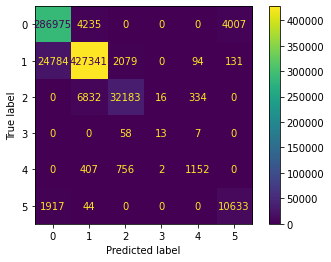

In [49]:
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [50]:
# metrics = {}
# metrics["precision_micro"] = sklearn.metrics.precision_score(
#     y_true=y_test, y_pred=y_pred, average="micro"
# )
# metrics["precision_macro"] = sklearn.metrics.precision_score(
#     y_true=y_test, y_pred=y_pred, average="macro"
# )

# for name, value in metrics.items():
#     print(f"{name} : {metrics[name]}")


precision_micro : 0.9431554726368159
precision_macro : 0.7785438316494805


In [141]:
df_test["Cover_Type"] = le.inverse_transform(xgb_classifier.predict(X_out))
df_test[["Id", "Cover_Type"]].to_csv(dataset_path.joinpath(f"{model_name}.csv"), index=False)


In [ ]:
df_test[["Id", "Cover_Type"]]

In [33]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from typing import List
import pl_bolts


In [48]:
dataset = pl_bolts.datamodules.SklearnDataModule(
    X=X_train,
    y=y_train,
    x_val=X_val,
    y_val=y_val,
    x_test=X_test,
    y_test=y_test,
    batch_size=32,
    random_state=42,
    num_workers=3,
)


In [74]:
input_dim = X_train.shape[1]
version = 1
logistic_regression = pl_bolts.models.LogisticRegression(
    input_dim=input_dim,
    num_classes=7,
    bias=True,
    l1_strength=0.2,
    l2_strength=0.5,
)
trainer = pl.Trainer(
    gpus=1,
    callbacks=[],
    accelerator="auto",
    enable_progress_bar=True,
    max_epochs=100,
    logger=[
        pl.loggers.CSVLogger(
            dataset_path.joinpath("logs").__str__(),
            f"logistic_regression",
            version=version,
        ),
        pl.loggers.TensorBoardLogger(
            dataset_path.joinpath("logs").__str__(),
            "logistic_regression",
            version=version,
        ),
    ],
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [75]:
trainer.fit(
    logistic_regression,
    train_dataloaders=dataset.train_dataloader(),
    val_dataloaders=dataset.val_dataloader(),
)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/daifukusan/.venv/data-science/lib/python3.9/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /home/daifukusan/Storage/datasets/tabular-playground-series-dec-2021/logs/logistic_regression/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 413   
----------------------------------
413       Trainable params
0         Non-trainable params
413       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(
    test_dataloaders=dataset.test_dataloader(batch_size=12),
)


In [66]:
layers = nn.Sequential()
layers.add_module()


In [68]:
class MLP(pl.LightningModule):
    def __init__(self, input_size: int, output_size: int, layers: List[int]):
        super().__init__()

        if len(layers) < 1:
            raise ValueError("`layers` must contain at least one integer.")

        modules = [nn.Linear(input_size, layers[0])]
        layers = layers.copy().append(output_size)

        for i in range(len(layers)):
            modules.append(nn.ReLU())
            modules.append(nn.Linear(layers[i], layers[i + 1]))

        self.layers = nn.Sequential(*modules)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.layers(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


In [ ]:
torch.

In [ ]:
pl.seed_everything(42)
mlp = MLP(
    input_size=len(numeric_cols(df_train) + one_hot_cols(df_train)),
    output_size=7,
    layers=[64, 64, 32],
)
trainer = pl.Trainer(
    auto_scale_batch_size="power", gpus=0, deterministic=True, max_epochs=5
)
trainer.fit(mlp, DataLoader(dataset))
